In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo

# 设置matplotlib的中文字体为SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
# plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [121]:
def plot_significant_correlation_matrix(df):
    """
    绘制有显著性因素的DataFrame的相关系数矩阵的热图。
    Parameters:
    - df (pandas.DataFrame): The input DataFrame containing the data.
    Returns:
    - None
    该函数计算输入DataFrame中所有因素两两之间的相关系数和p值，然后筛选出p值小于等于0.05的因素对。
    接着，使用这些显著性因素构建新的DataFrame，并计算新DataFrame的相关系数矩阵。
    最后，绘制新DataFrame的相关系数矩阵的热图，只显示下半对角矩阵，并在相关系数上方添加p值的注释。
    """
    # 计算p值和相关系数
    p_values = {}
    correlations = {}
    for i, col1 in enumerate(df.columns):
        for j, col2 in enumerate(df.columns[i+1:], i+1):  # 从i+1开始，避免重复
            corr, p_value = pearsonr(df[col1], df[col2])
            p_values[(col1, col2)] = p_value
            correlations[(col1, col2)] = corr

    # 筛选出p值小于等于0.05的因素对
    significant_pairs = [pair for pair, p_value in p_values.items() if p_value <= 0.05]

    # 打印所有显著相关因素的相关系数和p值，避免重复
    for pair in significant_pairs:
        col1, col2 = pair
        print(f"{col1}和{col2}的相关系数是{correlations[pair]:.2f}，p值为{p_values[pair]:.4f}")

    # 获取所有独特的显著性因素
    significant_factors = set()
    for pair in significant_pairs:
        significant_factors.update(pair)

    # 使用显著性因素构建新的DataFrame
    significant_df = df[list(significant_factors)]

    # 计算新DataFrame的相关系数矩阵
    corr_matrix = significant_df.corr()

    # 准备注释矩阵
    annotations = np.empty_like(corr_matrix, dtype=object)
    for i, row in enumerate(corr_matrix.index):
        for j, col in enumerate(corr_matrix.columns):
            if i > j:  # 只注释下半矩阵
                p_value = p_values.get((row, col), p_values.get((col, row)))
                annotations[i, j] = f"{corr_matrix.loc[row, col]:.2f}"
                if p_value <= 0.05:
                    annotations[i, j] += "*"
                if p_value <= 0.01:
                    annotations[i, j] += "*"
                if p_value <= 0.001:
                    annotations[i, j] += "*"

    # 计算mask用于隐藏上半对角矩阵
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # 使用mask绘制热图，只显示下半对角矩阵，并添加注释
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=annotations, fmt="", cmap='coolwarm', cbar=True)
    plt.title('显著性因素的相关系数矩阵')
    plt.show()

性别和专业方向的相关系数是-0.29，p值为0.0419
性别和因子2_总分的相关系数是-0.31，p值为0.0304
年级和入睡时间_时的相关系数是0.31，p值为0.0303
年级和熬夜频率_工作任务的相关系数是-0.33，p值为0.0241
年级和因子3_总分的相关系数是0.30，p值为0.0378
年级和因子4_总分的相关系数是0.45，p值为0.0014
年级和总得分的相关系数是0.32，p值为0.0268
专业方向和主观平均睡眠时间的相关系数是0.35，p值为0.0149
主观平均睡眠时间和熬夜频率_自我提升的相关系数是0.31，p值为0.0302
入睡时间_时和熬夜频率_自我提升的相关系数是-0.47，p值为0.0008
熬夜频率_工作任务和熬夜频率_自我提升的相关系数是0.54，p值为0.0001
熬夜频率_工作任务和因子4_总分的相关系数是-0.29，p值为0.0450
因子1_总分和因子2_总分的相关系数是0.42，p值为0.0030
因子1_总分和因子3_总分的相关系数是0.58，p值为0.0000
因子1_总分和总得分的相关系数是0.71，p值为0.0000
因子2_总分和因子3_总分的相关系数是0.61，p值为0.0000
因子2_总分和因子4_总分的相关系数是0.37，p值为0.0087
因子2_总分和总得分的相关系数是0.82，p值为0.0000
因子3_总分和因子4_总分的相关系数是0.43，p值为0.0022
因子3_总分和总得分的相关系数是0.87，p值为0.0000
因子4_总分和总得分的相关系数是0.64，p值为0.0000


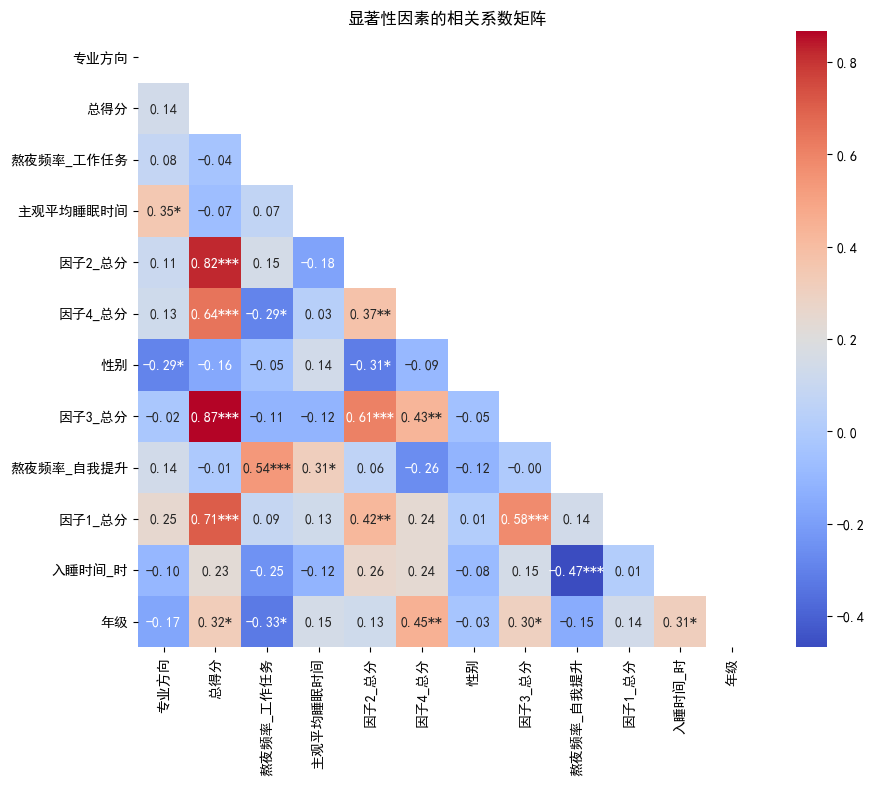

In [122]:
#相关性分析
df = pd.read_csv('问卷结果.csv', encoding='utf-8')
# Update the '入睡时间_时' column
df['入睡时间_时'] = df['入睡时间_时'].apply(lambda x: 0 if x <= 24 else 1)
# 假设df是你的DataFrame
plot_significant_correlation_matrix(df)

In [123]:
def perform_factor_analysis(df):
	# 计算KMO测试值
	kmo_all, kmo_model = calculate_kmo(df)
	print('KMO test value is {0:0.3f}'.format(kmo_model))

	if kmo_model < 0.5:
		print("KMO test value is less than 0.5, factor analysis is not recommended.")
		return
	else:
		# 遍历因子数量1-10，绘制不同因子数下最高累积能够表达的方差比例的折线图
		cumulative_variances = []
		for n in range(1, 11):
			fa = FactorAnalyzer(n_factors=n, rotation=None)
			fa.fit(df)
			ev, v, cumulative_variance = fa.get_factor_variance()
			cumulative_variances.append(cumulative_variance[-1])

		plt.figure(figsize=(10, 6))
		plt.plot(range(1, 11), cumulative_variances, marker='o', linestyle='-', color='b')
		plt.title('不同因子数量下的累积方差比例')
		plt.xlabel('因子数量')
		plt.ylabel('可解释的方差比例')
		plt.xticks(range(1, 11))
		plt.grid(True)
		plt.show()

		# 选择最大值所在的因子数量进行因子分析
		optimal_n_factors = np.argmax(cumulative_variances) + 1
		print(f"最佳因子数: {optimal_n_factors}")

		fa = FactorAnalyzer(n_factors=optimal_n_factors, rotation='varimax')
		fa.fit(df)
		loadings = fa.loadings_
		variable_names = df.columns
		df_loadings = pd.DataFrame(loadings, index=variable_names, columns=[f"Factor{i+1}" for i in range(loadings.shape[1])])

		# 绘制热力图
		plt.figure(figsize=(10, 10))
		sns.heatmap(df_loadings, annot=True, cmap='RdBu_r')
		plt.title('Factor Loadings Heatmap')
		plt.show()

KMO test value is 0.528


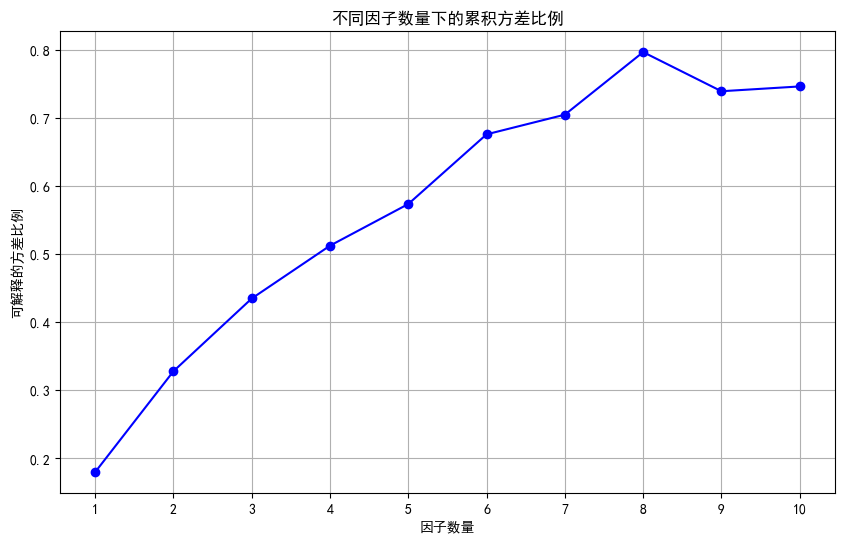

最佳因子数: 8


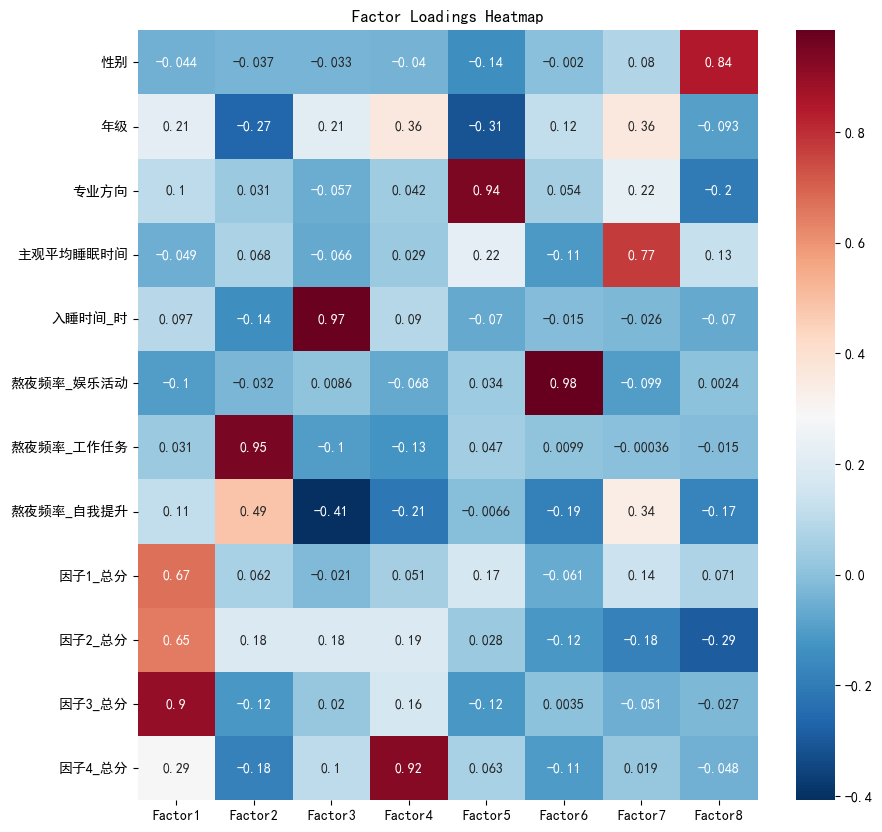

In [124]:
#去掉总分观察因子分析结果。虽然结果可观，但是KMO分数偏低，考虑删去一些列
df = pd.read_csv('问卷结果.csv')
#删去列
df = df.drop(['总得分'],axis=1)
# 将入睡时间_时列中小于等于24的填充0，大于24的填充1
df.loc[df['入睡时间_时']<=24,'入睡时间_时']=0
df.loc[df['入睡时间_时'] > 24, '入睡时间_时'] = 1
df.head()
perform_factor_analysis(df)

KMO test value is 0.648


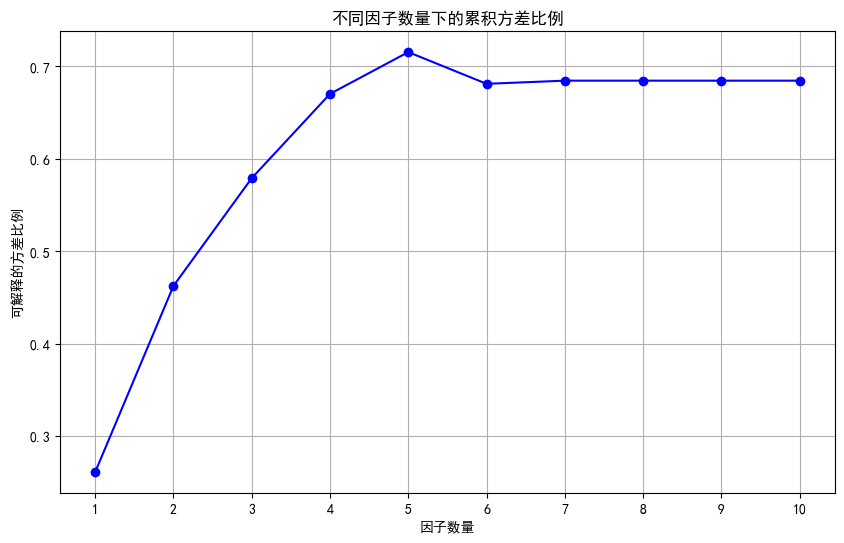

最佳因子数: 5


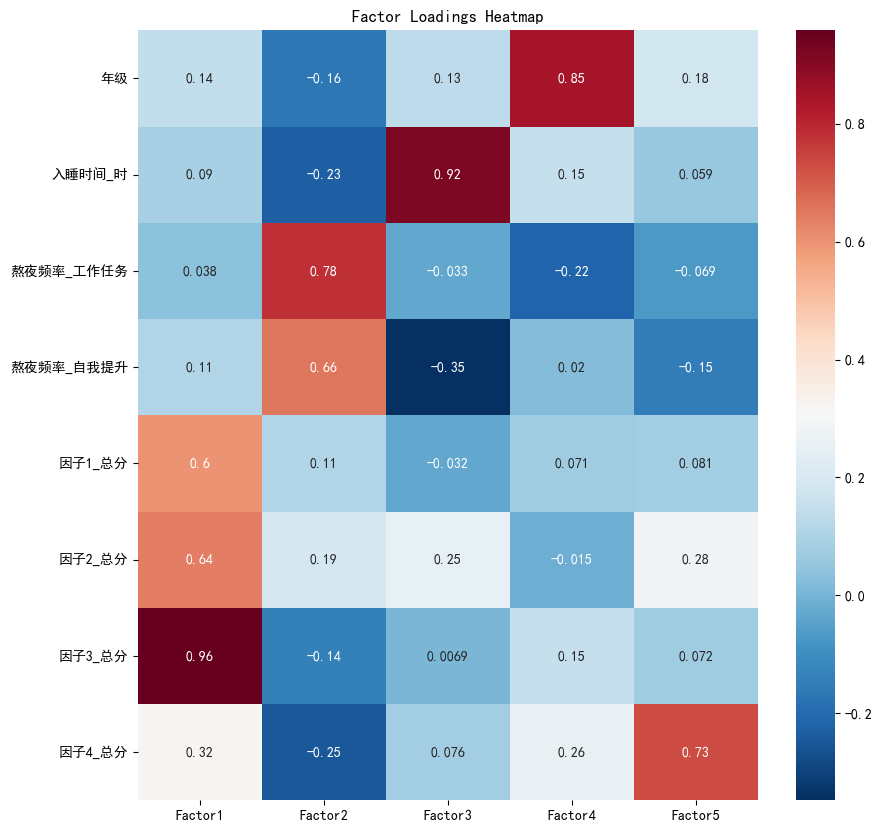

In [125]:
# 删去的列是通过观察相关性矩阵，删去与其他列相关性较低的列得到的
df = pd.read_csv('问卷结果.csv')
#删去列
df = df.drop(['总得分'],axis=1)
df = df.drop(['性别'],axis=1)
df = df.drop(['熬夜频率_娱乐活动'],axis=1)
df = df.drop(['主观平均睡眠时间'],axis=1)
df = df.drop(['专业方向'],axis=1)
# 将入睡时间_时列中小于等于24的填充0，大于24的填充1
df.loc[df['入睡时间_时']<=24,'入睡时间_时']=0
df.loc[df['入睡时间_时'] > 24, '入睡时间_时'] = 1
df.head()
perform_factor_analysis(df)

d:\deeplearning\pytorchDML\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\deeplearning\pytorchDML\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\deeplearning\pytorchDML\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\deeplearning\pytorchDML\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak

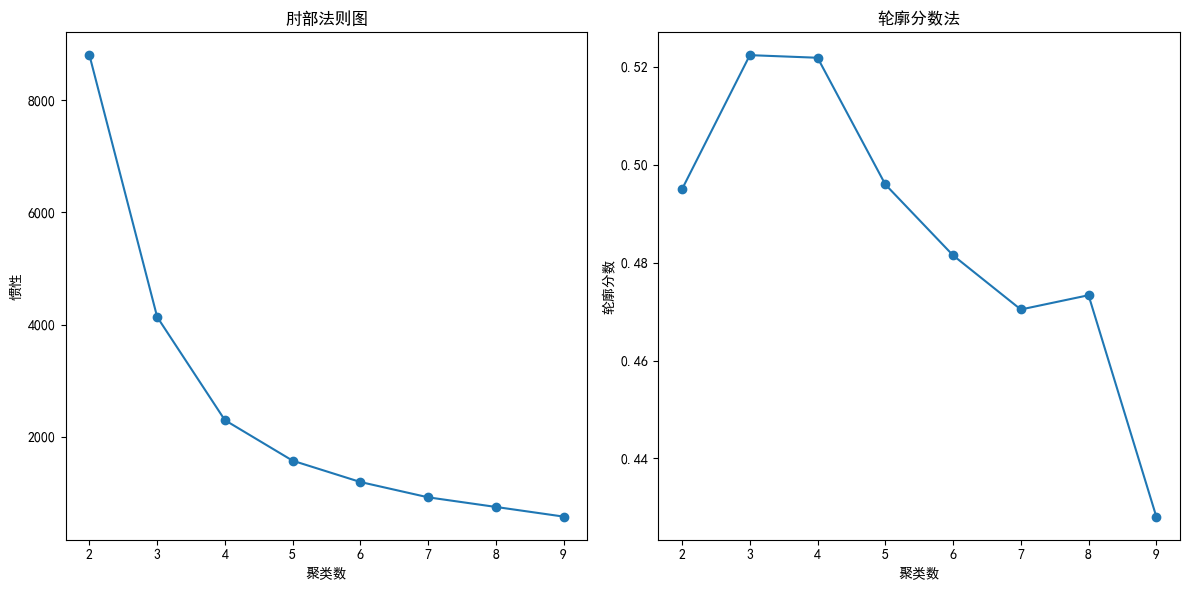

In [126]:
df = pd.read_csv('问卷结果.csv').drop(columns=['因子1_总分','因子2_总分','因子3_总分','因子4_总分'], axis=1)
# 将入睡时间_时列中小于等于24的填充0，大于24的填充1
df.loc[df['入睡时间_时']<=24,'入睡时间_时']=0
df.loc[df['入睡时间_时'] > 24, '入睡时间_时'] = 1
# 聚类确定最佳聚类数
silhouette_scores = []
inertia_list = np.empty(10)
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df)
    inertia_list[i] = kmeans.inertia_
    silhouette_scores.append(silhouette_score(df, kmeans.labels_))
# 绘制肘部图和轮廓分数图来确定最佳聚类数
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertia_list[2:10], '-o')
plt.title('肘部法则图')
plt.xlabel('聚类数')
plt.ylabel('惯性')
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette_scores, '-o')
plt.title('轮廓分数法')
plt.xlabel('聚类数')
plt.ylabel('轮廓分数')
plt.tight_layout()
plt.show()

In [127]:
# 假设最佳聚类数为k，根据上面的肘部图和轮廓分数图，这里设k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=4200)
kmeans.fit(df)

# 找到每个聚类中最靠近聚类中心的样本
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, df)
df = pd.read_csv('问卷结果.csv')
closest_samples = df.iloc[closest]

# 输出最靠近聚类中心的样本
print("最靠近聚类中心的样本:\n", closest_samples)

d:\deeplearning\pytorchDML\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\deeplearning\pytorchDML\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


最靠近聚类中心的样本:
     性别  年级  专业方向  主观平均睡眠时间  入睡时间_时  熬夜频率_娱乐活动  熬夜频率_工作任务  熬夜频率_自我提升  因子1_总分  \
2    1   3     2         6      28          2          1          4      26   
22   2   1     2         8      24          2          4          3      18   
0    1   3     2         7      23          3          3          4      26   

    因子2_总分  因子3_总分  因子4_总分  总得分  
2       26      27      16   95  
22       9       5       4   36  
0        9      21      11   67  


In [128]:
def get_lasso_coef(X, y,seed=42,cv_num=10):
    """
    计算Lasso回归的系数。

    参数:
    X: DataFrame，自变量数据。
    y: Series，因变量数据。

    返回:
    coef: Series，Lasso回归的系数。
    """
    # 标准化数据
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # # 使用MinMaxScaler进行标准化
    # scaler = MinMaxScaler()
    # X_scaled = scaler.fit_transform(X)
    
    # 使用LassoCV寻找最佳的alpha
    lasso = LassoCV(cv=cv_num, random_state=seed, max_iter=10000)
    lasso.fit(X_scaled, y)

    # 打印最佳的alpha值
    print(f"最佳的alpha值: {lasso.alpha_}")

    # 展示变量选择的过程
    coef = pd.Series(lasso.coef_, index = X.columns)
    print("Lasso选中的变量个数: " + str(sum(coef != 0)) + "个，被忽略的变量个数: " + str(sum(coef == 0)) + "个")

    # 计算R方值
    r_squared = lasso.score(X_scaled, y)
    print(f"R方值: {r_squared}")
    # 预测
    y_pred = lasso.predict(X_scaled)

    # 计算RMSE和MAE
    rmse = sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    print(f"均方根误差RMSE: {rmse}")
    print(f"平均绝对误差MAE: {mae}")
    # 获取截距
    intercept = lasso.intercept_
    print(f"截距: {intercept}")

    # 创建一个DataFrame来展示系数和截距
    coef_df = pd.DataFrame(lasso.coef_, index=X.columns, columns=['系数'])
    coef_df.loc['截距'] = intercept

    # 展示系数和截距的表格
    print(coef_df)

    return {'model':lasso,'scaler':scaler}#返回模型和标准化器

def calculate_vif(X):
    """
    计算并返回一个DataFrame，包含每个特征的VIF值。
    用于检测多重共线性。
    参数:
    - X: pandas DataFrame，包含所有特征。
    
    返回:
    - 一个DataFrame，包含每个特征的VIF值。
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    
    # 初始化VIF列表
    vif_values = []
    
    # 对每个特征计算VIF
    for i in range(X.shape[1]):
        # 选择作为因变量的特征
        y = X.iloc[:, i]
        
        # 选择作为自变量的其他特征
        X_except_i = X.drop(X.columns[i], axis=1)
        
        # 训练线性回归模型
        model = LinearRegression()
        model.fit(X_except_i, y)
        
        # 计算R^2值
        r_squared = model.score(X_except_i, y)
        
        # 计算VIF
        if r_squared < 1:  # 避免除以0
            vif = 1 / (1 - r_squared)
        else:
            vif = np.inf
        vif_values.append(vif)
    
    vif_data["VIF"] = vif_values
    return vif_data

In [129]:
#我们首先观察各个变量的VIF值，以检测多重共线性。除开总分与各因子分数的相关之后，发现数据中不存在多重共线性。
df = pd.read_csv('问卷结果.csv')
print("为四个因子检验的多重共线性")
X = df.drop(['总得分'],axis=1)
VIF_df = calculate_vif(X)
print(VIF_df)

为四个因子检验的多重共线性
      feature       VIF
0          性别  1.438763
1          年级  2.099634
2        专业方向  1.934901
3    主观平均睡眠时间  2.060935
4      入睡时间_时  1.789269
5   熬夜频率_娱乐活动  1.354295
6   熬夜频率_工作任务  1.942198
7   熬夜频率_自我提升  2.170707
8      因子1_总分  1.880203
9      因子2_总分  2.332695
10     因子3_总分  2.653259
11     因子4_总分  1.897599


In [130]:
df = pd.read_csv('问卷结果.csv')
df.loc[df['入睡时间_时']<=24,'入睡时间_时']=0
df.loc[df['入睡时间_时'] > 24, '入睡时间_时'] = 1
X, y = df.drop(columns=['入睡时间_时','总得分']), df['入睡时间_时']
model = get_lasso_coef(X, y)
# 首先对原数据X进行标准化
X_scaled = model['scaler'].transform(X)

# 使用模型进行预测
y_pred_continuous = model['model'].predict(X_scaled)

# 将连续的预测值转换为分类结果，这里以0.5作为阈值
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_continuous]

# 计算正确率
correct_predictions = sum(y_pred == y)
accuracy = correct_predictions / len(y)

print(f"模型在原数据上的正确率为: {accuracy:.2f}")

from scipy.stats import binomtest
# 观察到的成功次数（模型预测正确的次数）
successes = sum(y_pred == y)
# 总试验次数（数据点的总数）
n = len(y)
# 执行二项检验
result = binomtest(successes, n, p=0.5, alternative='two-sided')
p_value = result.pvalue
print(f"二项检验的p值为: {p_value:.4f}")
# 判断结果
if p_value < 0.05:
    print("模型的正确率显著地比随机猜测好。")
else:
    print("没有足够的证据表明模型的正确率显著地比随机猜测好。")

最佳的alpha值: 0.05794905400256912
Lasso选中的变量个数: 3个，被忽略的变量个数: 8个
R方值: 0.3108615080125069
均方根误差RMSE: 0.4150718287198895
平均绝对误差MAE: 0.38388610320076305
截距: 0.5
                 系数
性别        -0.000000
年级         0.063218
专业方向      -0.000000
主观平均睡眠时间  -0.000000
熬夜频率_娱乐活动 -0.000000
熬夜频率_工作任务 -0.000000
熬夜频率_自我提升 -0.171372
因子1_总分    -0.000000
因子2_总分     0.075070
因子3_总分     0.000000
因子4_总分     0.000000
截距         0.500000
模型在原数据上的正确率为: 0.75
二项检验的p值为: 0.0007
模型的正确率显著地比随机猜测好。


In [131]:
#主观睡眠时间是衡量睡眠质量的重要指标，我们尝试使用其他变量来预测主观睡眠时间，来探究睡眠质量的一部分影响因素。
df = pd.read_csv('问卷结果.csv')
# df.loc[df['入睡时间_时']<=24,'入睡时间_时']=0
# df.loc[df['入睡时间_时'] > 24, '入睡时间_时'] = 1
X, y = df.drop(columns=['总得分','主观平均睡眠时间']), df['主观平均睡眠时间']
model = get_lasso_coef(X, y)

最佳的alpha值: 0.023156116462705274
Lasso选中的变量个数: 10个，被忽略的变量个数: 1个
R方值: 0.5098924799548086
均方根误差RMSE: 0.8691200759725547
平均绝对误差MAE: 0.6854107425189406
截距: 7.145833333333333
                 系数
性别         0.273670
年级         0.500022
专业方向       0.553590
入睡时间_时    -0.415282
熬夜频率_娱乐活动 -0.202674
熬夜频率_工作任务  0.100047
熬夜频率_自我提升  0.144891
因子1_总分     0.080591
因子2_总分    -0.089384
因子3_总分    -0.198910
因子4_总分    -0.000000
截距         7.145833
